XGBoost Accuracy: 0.996
Classification Report:

Classification Report:
               precision    recall  f1-score   support

     No Rain       1.00      1.00      1.00       437
        Rain       0.97      1.00      0.98        63

    accuracy                           1.00       500
   macro avg       0.98      1.00      0.99       500
weighted avg       1.00      1.00      1.00       500



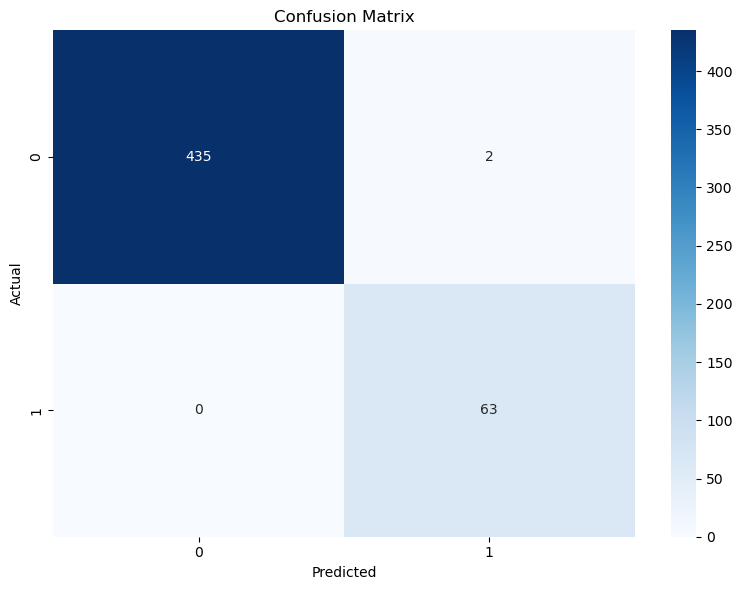

Predicted Grade: no rain ,for given weather input


C:\Users\oosun\AppData\Local\Temp\ipykernel_17616\3806857605.py:80: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_input = df_input.apply(pd.to_numeric, errors='ignore')


In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

#Step 1: Import CSVs
df_train = pd.read_csv('../Data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../Data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["Rain"])
y_train = df_train['Rain']

X_test = df_test.drop(columns=["Rain"])
y_test = df_test['Rain']

#Step 3: Build a pipeline and train XGBoost Model
pipeline = Pipeline(steps=[
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=47))
])

#Step 4: Define Param grid for tuning the model
param_grid = {
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1],
    'clf__n_estimators': [100, 200]
}

#Step 5: Training the XGBoost model using GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid.fit(X_train, y_train)

predictions = grid.predict(X_test)

best_model = grid.best_estimator_ 

#Step 6: Save the model as pkl file in artifacts
with open("../Artifacts/xgboost_model.pkl", "wb") as file:
   pickle.dump(best_model, file)

#Step 7:Make predictions
predictions = best_model.predict(X_test)

#Step 8: Evaluation
accuracy = accuracy_score(y_test, predictions)
print("XGBoost Accuracy:", accuracy)

print("Classification Report:")
print("\nClassification Report:\n", classification_report(y_test, predictions, target_names=["No Rain", "Rain"], zero_division=0))

#Confusion Matrix
cm = confusion_matrix(y_test, predictions)
labels = sorted(y_test.unique()) 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#Prediction function
def predict_weather(input_string):
    columns = ["Temperature", "Humidity", "Wind_Speed", "Cloud_Cover", "Pressure"]

    # Convert input string into a list
    input_data = input_string.split(",")

    # Create DataFrame from input
    df_input = pd.DataFrame([input_data], columns=columns)

    # Convert numerical values from strings to floats
    df_input = df_input.apply(pd.to_numeric, errors='ignore')  

    # Predict using the loaded model
    prediction = best_model.predict(df_input)
    
    # Rain map
    rain_map = {0: "no rain", 1: "rain"}
    
    predicted_rain = rain_map[prediction[0]]

    return predicted_rain

#Example testing input from the csv file
weather_input = "20.5,65,13.2,60,1012"

#Print predicted grade
print(f"Predicted Grade: {predict_weather(weather_input)} ,for given weather input")

#Step 9: Save predictions to CSV
comp_df = X_test.copy()
comp_df["Actual_Rain"] = y_test.values
comp_df["Predicted_Rain"] = predictions
comp_df.to_csv("../Artifacts/xgboost_prediction.csv", index=False)